In [26]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-mask-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F809358%2F1386555%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T215015Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0e4b88e77ac8a2f47876b429d011ac3ba25420775a6bb8386ff04f303cdbb3da831296ddcea0f0945e089dbda541fbe1e2451f78d6a3115c6896250f8de0d8faca90d9c73b2913f31daebfb822962eb52e58e217b091311d55453f5dd6be4347babf6f18a231ed1083c8e8b88ed7669f5f9c992adc0229e134fdf73c6bd2dfc6e70c60cb6a2368838ec57d17e233be5e78ada2e8602bddf288e0be8c1b7bf378a0186dd4e6ed56d04b405f455924027fd0af798f60af5fb7184d818ac7cb117cdb1f3854e2d07f5979782155f009fa879670c3959c157cdaaa96b0b8fd728561335a988c14eb4ce74d785be631b7ca9bd58f55e46ebe6d41beb2c68dd474cc6f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 171127690 bytes downloaded
Downloaded and uncompressed: face-mask-dataset
Data source import complete.


In [4]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import os

import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras import applications
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, Sequential, optimizers, callbacks

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
data_link = "/kaggle/input/face-mask-dataset"

dataset = {"images":[], "labels":[]}

for data in os.listdir(data_link):
    data_path = os.path.join(data_link, data)
    for images in os.listdir(data_path):
        image_link = os.path.join(data_path, images)
        for img in os.listdir(image_link):
            loaded_img = os.path.join(image_link, img)
            dataset["images"].append(loaded_img)
            dataset["labels"].append(images)

df = pd.DataFrame(dataset)

df.head()

,images,labels
0,/kaggle/input/face-mask-dataset/data/with_mask...,with_mask
1,/kaggle/input/face-mask-dataset/data/with_mask...,with_mask
2,/kaggle/input/face-mask-dataset/data/with_mask...,with_mask
3,/kaggle/input/face-mask-dataset/data/with_mask...,with_mask
4,/kaggle/input/face-mask-dataset/data/with_mask...,with_mask


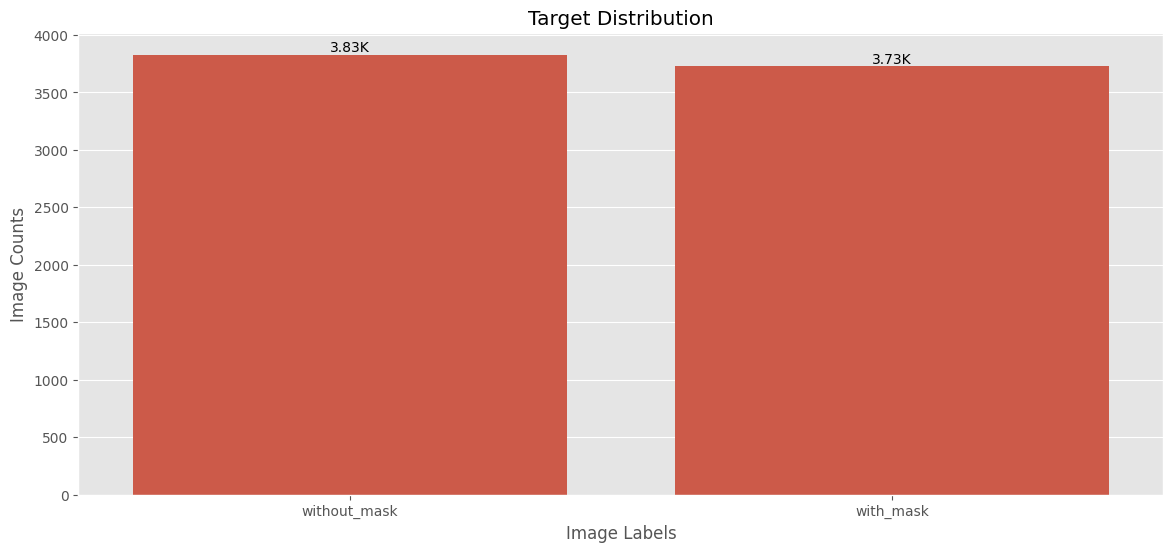

In [ ]:
value_count = df["labels"].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
barplot = sns.barplot(x=value_count.index, y=value_count.values)
barplot.set_xlabel("Image Labels")
barplot.set_ylabel("Image Counts")
barplot.set_title("Target Distribution")

for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000:.2f}K", ha="center", va="bottom")

plt.show()

## Exploratory Data Analysis

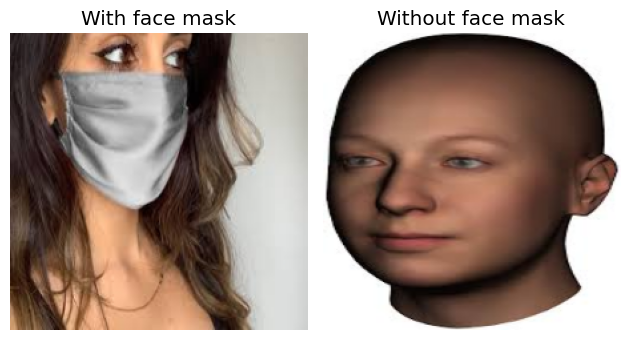

In [ ]:
with_mask = df[df["labels"] == "with_mask"]

without_mask = df[df["labels"] == "without_mask"]

rand_with_mask = np.random.randint(with_mask.index[0], with_mask.index[-1], 1)

rand_without_mask = np.random.randint(without_mask.index[0], without_mask.index[-1], 1)

index = 1
for (i, j) in zip(rand_with_mask, rand_without_mask):
    plt.subplot(1, 2, index)
    plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(df.loc[i, "images"]), cv2.COLOR_BGR2RGB), (224, 224)))
    plt.title("With face mask")
    plt.axis("off")
    index+=1
    plt.subplot(1, 2, index)
    plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(df.loc[j, "images"]), cv2.COLOR_BGR2RGB), (224, 224)))
    plt.title("Without face mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

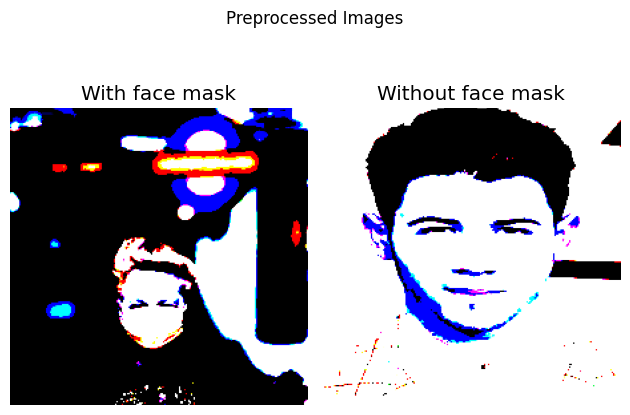

In [ ]:
with_mask = df[df["labels"] == "with_mask"]

without_mask = df[df["labels"] == "without_mask"]

rand_with_mask = np.random.randint(with_mask.index[0], with_mask.index[-1], 1)

rand_without_mask = np.random.randint(without_mask.index[0], without_mask.index[-1], 1)

index = 1
for (i, j) in zip(rand_with_mask, rand_without_mask):
    plt.subplot(1, 2, index)
    plt.imshow(cv2.resize(applications.vgg19.preprocess_input(cv2.cvtColor(cv2.imread(df.loc[i, "images"]), cv2.COLOR_BGR2RGB)), (224, 224)))
    plt.title("With face mask")
    plt.axis("off")
    index+=1
    plt.subplot(1, 2, index)
    plt.imshow(cv2.resize(applications.vgg19.preprocess_input(cv2.cvtColor(cv2.imread(df.loc[j, "images"]), cv2.COLOR_BGR2RGB)), (224, 224)))
    plt.title("Without face mask")
    plt.axis("off")

plt.suptitle("Preprocessed Images")
plt.tight_layout()
plt.show()

### Train Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df["images"], df["labels"], test_size=0.1,stratify=df["labels"], random_state=42)

x_test, x_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, stratify=y_test, random_state=42)


train_images = pd.concat([X_train, y_train], axis="columns")

test_images = pd.concat([x_test, y_test], axis="columns")

validation_images = pd.concat([x_val, y_val], axis="columns")

### Load Data

In [29]:
image_generator_1 = ImageDataGenerator(preprocessing_function=applications.vgg19.preprocess_input)
image_generator_2 = ImageDataGenerator(preprocessing_function=applications.xception.preprocess_input)
image_generator_3 = ImageDataGenerator(preprocessing_function=applications.mobilenet.preprocess_input)


train_img_gen_1 = image_generator_1.flow_from_dataframe(dataframe=train_images,
                                                        x_col=train_images.columns[0],
                                                        y_col=train_images.columns[1],
                                                        color_mode="rgb",
                                                        shuffle=True,
                                                        target_size=(224, 224),
                                                        seed=42,
                                                        class_mode="categorical")

train_img_gen_2 = image_generator_2.flow_from_dataframe(dataframe=train_images,
                                                        x_col=train_images.columns[0],
                                                        y_col=train_images.columns[1],
                                                        color_mode="rgb",
                                                        shuffle=True,
                                                        target_size=(224, 224),
                                                        seed=42,
                                                        class_mode="categorical")


train_img_gen_3 = image_generator_3.flow_from_dataframe(dataframe=train_images,
                                                        x_col=train_images.columns[0],
                                                        y_col=train_images.columns[1],
                                                        color_mode="rgb",
                                                        shuffle=True,
                                                        target_size=(224, 224),
                                                        seed=42,
                                                        class_mode="categorical")

test_img_gen_1 = image_generator_1.flow_from_dataframe(dataframe=test_images,
                                                        x_col=train_images.columns[0],
                                                        y_col=train_images.columns[1],
                                                        color_mode="rgb",
                                                        shuffle=True,
                                                        target_size=(224, 224),
                                                        seed=42,
                                                        class_mode="categorical")

test_img_gen_2 = image_generator_2.flow_from_dataframe(dataframe=test_images,
                                                        x_col=train_images.columns[0],
                                                        y_col=train_images.columns[1],
                                                        color_mode="rgb",
                                                        shuffle=True,
                                                        target_size=(224, 224),
                                                        seed=42,
                                                        class_mode="categorical")


test_img_gen_3 = image_generator_3.flow_from_dataframe(dataframe=test_images,
                                                        x_col=train_images.columns[0],
                                                        y_col=train_images.columns[1],
                                                        color_mode="rgb",
                                                        shuffle=True,
                                                        target_size=(224, 224),
                                                        seed=42,
                                                        class_mode="categorical")

Found 6797 validated image filenames belonging to 2 classes.
Found 6797 validated image filenames belonging to 2 classes.
Found 6797 validated image filenames belonging to 2 classes.
Found 680 validated image filenames belonging to 2 classes.
Found 680 validated image filenames belonging to 2 classes.
Found 680 validated image filenames belonging to 2 classes.


### Modelling

In [ ]:
vgg19_model = applications.VGG19(include_top=False,
                                 weights="imagenet",
                                 input_shape=train_img_gen_1.image_shape)

xception_model = applications.Xception(include_top=False,
                                       weights="imagenet",
                                       input_shape=train_img_gen_2.image_shape)

mobilenet_model = applications.MobileNet(include_top=False,
                                         weights="imagenet",
                                         input_shape=train_img_gen_3.image_shape)

17225924/17225924 [==============================] - 0s 0us/step


## Data Augmentation Layer

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomZoom(height_factor=0.2, width_factor=0.1),
    layers.RandomRotation(factor=0.01),
    layers.RandomContrast(factor=0.4)
], name="data_augmentation_layer")

In [ ]:
model_1 = Sequential([
    layers.Input(shape=(224, 224, 3), name="input_layer"),
    data_augmentation,
    layers.Lambda(applications.vgg19.preprocess_input, name='vgg19_preprocess_input'),
    vgg19_model,
    layers.GlobalAveragePooling2D(),
   # layers.Flatten(),
    layers.Dense(units=1024, activation="relu"),
    layers.Dropout(rate=0.5),
    layers.BatchNormalization(),
    layers.Dense(units=2, activation="sigmoid")
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation_layer (S  (None, 224, 224, 3)       0         
 equential)                                                      
                                                                 
 vgg19_preprocess_input (La  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                        

In [ ]:
model_1.compile(optimizer=optimizers.RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
vgg19_model.trainable = False

history_1 = model_1.fit(train_img_gen_1,
                        validation_data=test_img_gen_1,
                        epochs=20, batch_size=32,
                        callbacks=[callbacks.EarlyStopping(patience=5, monitor="val_loss")])

Epoch 1/20
213/213 [==============================] - 150s 570ms/step - loss: 0.6079 - accuracy: 0.7066 - val_loss: 511.0038 - val_accuracy: 0.3647
Epoch 2/20
213/213 [==============================] - 106s 496ms/step - loss: 0.4266 - accuracy: 0.8124 - val_loss: 0.4098 - val_accuracy: 0.8029
Epoch 3/20
213/213 [==============================] - 106s 496ms/step - loss: 0.3409 - accuracy: 0.8554 - val_loss: 0.2979 - val_accuracy: 0.8735
Epoch 4/20
213/213 [==============================] - 106s 497ms/step - loss: 0.2811 - accuracy: 0.8925 - val_loss: 0.5405 - val_accuracy: 0.8426
Epoch 5/20
213/213 [==============================] - 108s 505ms/step - loss: 0.2607 - accuracy: 0.8957 - val_loss: 0.5060 - val_accuracy: 0.8382
Epoch 6/20
213/213 [==============================] - 106s 498ms/step - loss: 0.2378 - accuracy: 0.9050 - val_loss: 1.8641 - val_accuracy: 0.5147
Epoch 7/20
213/213 [==============================] - 106s 499ms/step - loss: 0.2143 - accuracy: 0.9178 - val_loss: 0.2463

### Model Evaluation

<Axes: >

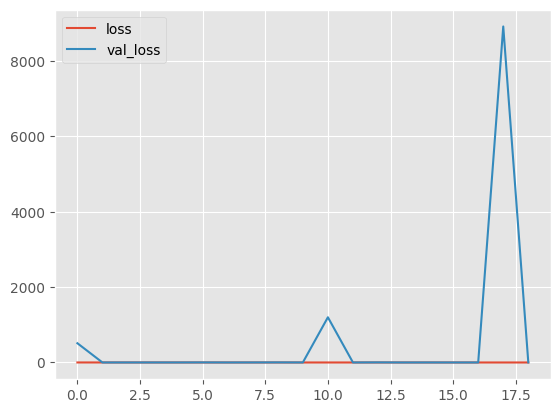

In [ ]:
pd.DataFrame(history_1.history)[["loss", "val_loss"]].plot()

<Axes: >

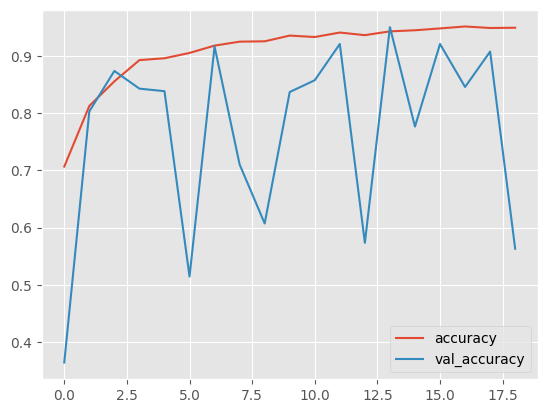

In [ ]:
pd.DataFrame(history_1.history)[["accuracy", "val_accuracy"]].plot()

In [ ]:
model_1.save("/content/drive/MyDrive/FaceMaskDetection/Models/model_1.h5")

### Fine-tuning model_1

In [ ]:
vgg19_model.trainable = True
for layer in vgg19_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layers.trainable = False

model_1_fine_tune = Sequential([
    layers.Input(shape=(224, 224, 3), name="input_layer"),
    data_augmentation,
    layers.Lambda(applications.vgg19.preprocess_input, name='vgg19_preprocess_input'),
    vgg19_model,
    layers.GlobalAveragePooling2D(),
   # layers.Flatten(),
    layers.Dense(units=1024, activation="relu"),
    layers.Dropout(rate=0.5),
    layers.BatchNormalization(),
    layers.Dense(units=2, activation="sigmoid")
])

model_1_fine_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation_layer (S  (None, None, None, None   0         
 equential)                  )                                   
                                                                 
 vgg19_preprocess_input (La  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                      

In [ ]:
model_1_fine_tune.compile(optimizer=optimizers.RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history_1_fine_tuned = model_1_fine_tune.fit(train_img_gen_1,
                                             validation_data=test_img_gen_1,
                                             epochs=20, batch_size=32,
                                             callbacks=[callbacks.EarlyStopping(patience=5, monitor="val_loss")])

Epoch 1/20
213/213 [==============================] - 111s 503ms/step - loss: 0.1515 - accuracy: 0.9435 - val_loss: 0.2872 - val_accuracy: 0.9338
Epoch 2/20
213/213 [==============================] - 107s 502ms/step - loss: 0.1294 - accuracy: 0.9513 - val_loss: 0.2127 - val_accuracy: 0.9191
Epoch 3/20
213/213 [==============================] - 107s 501ms/step - loss: 0.1350 - accuracy: 0.9476 - val_loss: 0.1214 - val_accuracy: 0.9515
Epoch 4/20
213/213 [==============================] - 107s 502ms/step - loss: 0.1218 - accuracy: 0.9547 - val_loss: 0.2663 - val_accuracy: 0.9103
Epoch 5/20
213/213 [==============================] - 108s 509ms/step - loss: 0.1241 - accuracy: 0.9538 - val_loss: 4.6764 - val_accuracy: 0.9456
Epoch 6/20
213/213 [==============================] - 107s 502ms/step - loss: 0.1126 - accuracy: 0.9569 - val_loss: 0.5631 - val_accuracy: 0.8015
Epoch 7/20
213/213 [==============================] - 107s 501ms/step - loss: 0.1099 - accuracy: 0.9581 - val_loss: 0.1613 -

<Axes: >

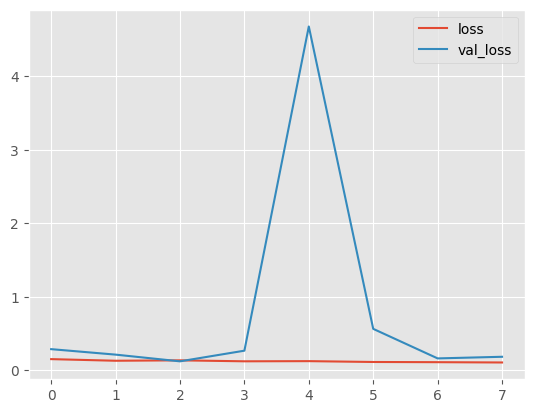

In [ ]:
pd.DataFrame(history_1_fine_tuned.history)[["loss", "val_loss"]].plot()

<Axes: >

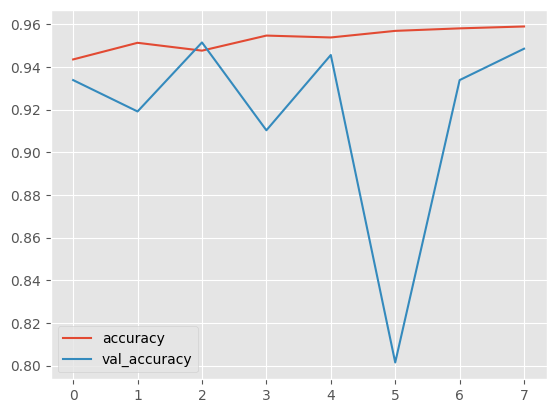

In [ ]:
pd.DataFrame(history_1_fine_tuned.history)[["accuracy", "val_accuracy"]].plot()

In [ ]:
model_1_fine_tune.save("/content/drive/MyDrive/FaceMaskDetection/Models/model_1_fine_tune.h5")

In [5]:
loaded_fine_tuned_model = load_model("/content/drive/MyDrive/FaceMaskDetection/Models/model_1_fine_tune.h5")

In [6]:
loaded_fine_tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation_layer (S  (None, None, None, None   0         
 equential)                  )                                   
                                                                 
 vgg19_preprocess_input (La  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                      

## Model Validation

In [34]:
classes = {val:key for key, val in train_img_gen_1.class_indices.items()}

1/1 [==============================] - 0s 84ms/step


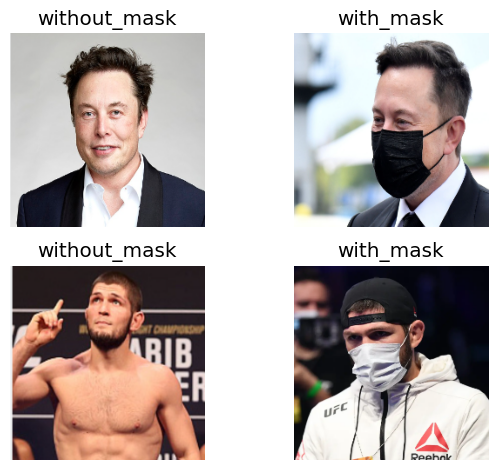

In [36]:
test_path = "/content/drive/MyDrive/FaceMaskDetection/test_images"

for idx, img_path in enumerate(os.listdir(test_path), start=1):
  image_path = os.path.join(test_path, img_path)
  image = cv2.resize(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), (224, 224))
  prep_image = applications.vgg19.preprocess_input(image)
  prediction = loaded_fine_tuned_model.predict(np.expand_dims(prep_image, axis=0))
  plt.subplot(2, 2, idx)
  plt.title(classes[np.argmax(prediction)])
  plt.imshow(image)
  plt.axis("off")

plt.tight_layout()
plt.show()